In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler


In [3]:

IMG_SIZE = 160
BATCH_SIZE = 64
TRAIN_DIR = "GTSRB_cleaned/train"
VAL_DIR = "GTSRB_cleaned/val"


In [5]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    brightness_range=[0.8, 1.2]
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

num_classes = len(train_generator.class_indices)


Found 31367 images belonging to 43 classes.
Found 7842 images belonging to 43 classes.


In [7]:

base_model = VGG16(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [9]:

def lr_scheduler(epoch, lr):
    if epoch > 10:
        return lr * 0.5
    return lr

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    ModelCheckpoint('vgg16_best_model.keras', save_best_only=True, monitor='val_loss', mode='min'),
    LearningRateScheduler(lr_scheduler)
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=callbacks,
    verbose=1
)


C:\Users\hp\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 3944s 8s/step - accuracy: 0.2677 - loss: 2.6420 - val_accuracy: 0.5332 - val_loss: 1.5836 - learning_rate: 0.0010
Epoch 2/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 4031s 8s/step - accuracy: 0.5168 - loss: 1.5706 - val_accuracy: 0.6135 - val_loss: 1.2672 - learning_rate: 0.0010
Epoch 3/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 5061s 10s/step - accuracy: 0.6006 - loss: 1.2972 - val_accuracy: 0.6637 - val_loss: 1.0784 - learning_rate: 0.0010
Epoch 4/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 4009s 8s/step - accuracy: 0.6382 - loss: 1.1453 - val_accuracy: 0.6928 - val_loss: 0.9772 - learning_rate: 0.0010
Epoch 5/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 4101s 8s/step - accuracy: 0.6705 - loss: 1.0471 - val_accuracy: 0.7318 - val_loss: 0.8776 - learning_rate: 0.0010
Epoch 6/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 3684s 8s/step - accuracy: 0.6902 - loss: 0.9889 - val_accuracy: 0.7332 - val_loss: 0.8412 - learning_rate: 0.0010
Epoch 7/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 4050s 8s/step - accuracy: 0.7003 - 

In [11]:

base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=5e-5), loss='categorical_crossentropy', metrics=['accuracy'])

fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 7100s 14s/step - accuracy: 0.7640 - loss: 0.9711 - val_accuracy: 0.9739 - val_loss: 0.0782 - learning_rate: 5.0000e-05
Epoch 2/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 7571s 15s/step - accuracy: 0.9702 - loss: 0.0938 - val_accuracy: 0.9880 - val_loss: 0.0356 - learning_rate: 5.0000e-05
Epoch 3/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 7416s 15s/step - accuracy: 0.9846 - loss: 0.0456 - val_accuracy: 0.9950 - val_loss: 0.0159 - learning_rate: 5.0000e-05
Epoch 4/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 33182s 68s/step - accuracy: 0.9917 - loss: 0.0236 - val_accuracy: 0.9953 - val_loss: 0.0164 - learning_rate: 5.0000e-05
Epoch 5/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 7203s 15s/step - accuracy: 0.9949 - loss: 0.0192 - val_accuracy: 0.9971 - val_loss: 0.0088 - learning_rate: 5.0000e-05
Epoch 6/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 7485s 15s/step - accuracy: 0.9955 - loss: 0.0149 - val_accuracy: 0.9971 - val_loss: 0.0110 - learning_rate: 5.0000e-05
Epoch 7/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 11585

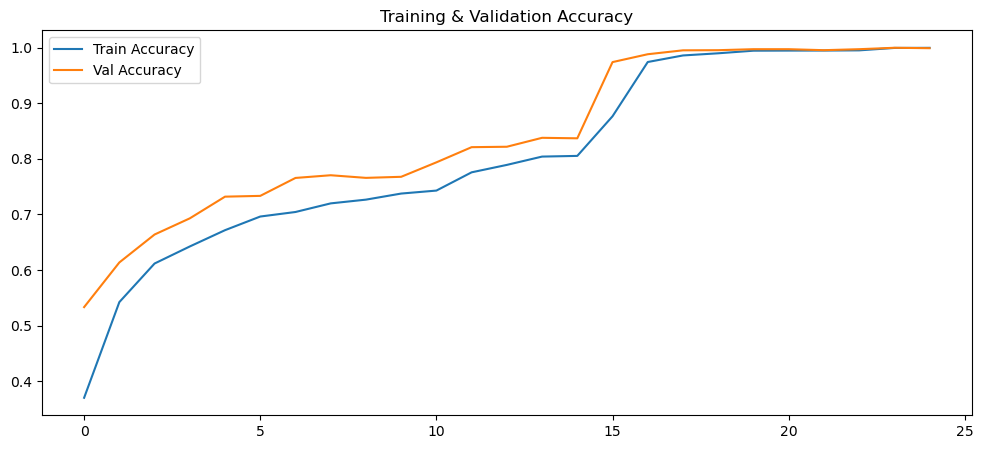

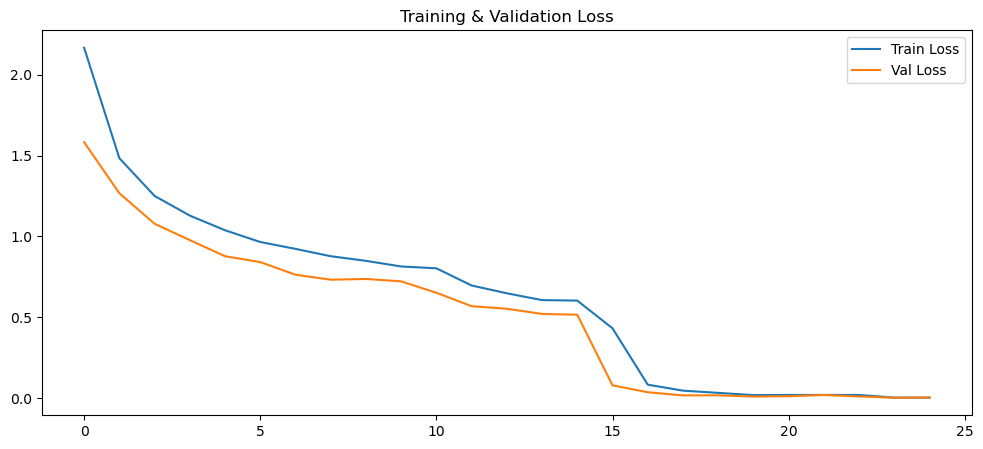

In [13]:

plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'] + fine_tune_history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + fine_tune_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'] + fine_tune_history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + fine_tune_history.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()
